In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/cps-earnings/clean/"
data_out = dirname + "da_case_studies/ch10-gender-earnings-understand/"
output = dirname + "da_case_studies/ch10-gender-earnings-understand/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [4]:
cps = pd.read_csv(data_in + "morg-2014-emp.csv")

In [5]:
cps = cps.query("uhours>=20 & earnwke>0 & age>=24 & age<=64 & grade92>=44")

In [6]:
# CREATE VARIABLES
cps["female"]=(cps.sex==2).astype(int)
cps["w"]=cps["earnwke"]/cps["uhours"]
cps["lnw"]=np.log(cps["w"])
## Write out to csv
cps.to_csv(data_out+"earnings_multireg.csv")

In [7]:
#####################
#DISTRIBUTION OF EARNINGS
#######################
cps.loc[:,["earnwke","uhours","w"]].describe()

,earnwke,uhours,w
count,18241.00000,18241.000000,18241.000000
mean,1481.78936,42.970780,34.525791
std,747.92426,9.139368,16.654215
min,0.01000,20.000000,0.000200
25%,923.00000,40.000000,21.634500
50%,1346.00000,40.000000,31.250000
75%,1923.07000,47.000000,45.673000
max,2884.61000,99.000000,144.230500


In [8]:
cps.loc[cps.w>=1,["earnwke","uhours","w"]].describe()

,earnwke,uhours,w
count,18220.000000,18220.000000,18220.000000
mean,1483.491212,42.970088,34.565432
std,746.672256,9.135281,16.622801
min,38.000000,20.000000,1.025556
25%,923.000000,40.000000,21.634500
50%,1346.000000,40.000000,31.250000
75%,1923.070000,47.000000,45.673000
max,2884.610000,99.000000,144.230500


In [9]:
################################################################
# LN EARNINGS, GENDER, AGE
# robust standard error
reg=smf.ols(formula="lnw~female",data=cps).fit(cov_type="HC1")
reg2=smf.ols(formula="lnw~female+age",data=cps).fit(cov_type="HC1")
reg3=smf.ols(formula="age~female",data=cps).fit(cov_type="HC1")

In [10]:
Stargazer([reg,reg2,reg3])

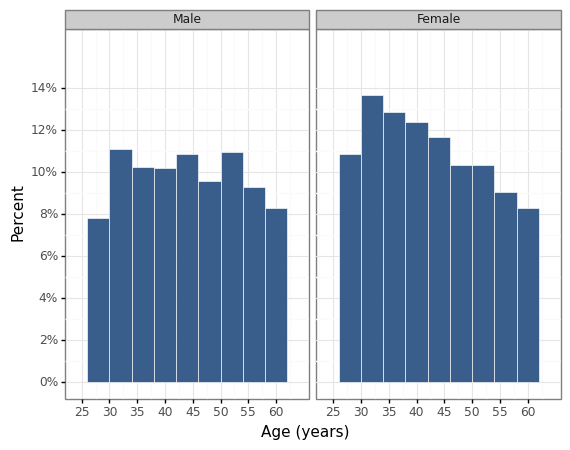

<ggplot: (319251661)>

In [11]:
ggplot(cps, aes(x="age", y="2*stat(count)/sum(stat(count))")) + geom_histogram(
    binwidth=4,
    color="white",
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + labs(x="Age (years)", y="Percent") + facet_wrap('~female',labeller={'0':"Male",'1':"Female"}
) + labs(
    x="Age (years)", y="Percent"
) + scale_x_continuous(
    limits=(24, 64), breaks=seq(25, 65, by=5),
) + scale_y_continuous(
    limits=(0, 0.16), breaks=seq(0, 0.16, by=0.02), labels=percent_format()
) + theme_bw()

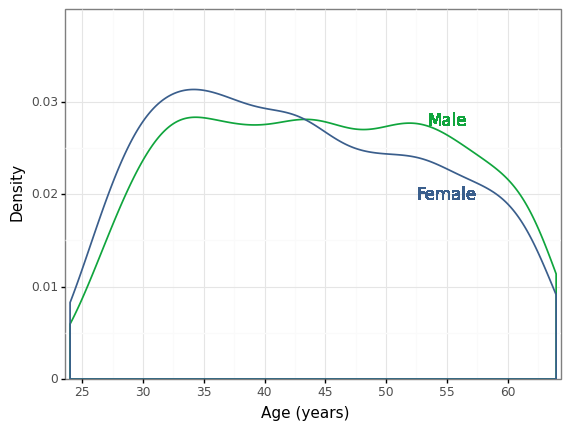

<ggplot: (319397027)>

In [12]:
ggplot(cps, aes(x="age", y="stat(density)", color="factor(female)")) + geom_density(
    adjust=1.5, show_legend=False, na_rm=True, size=0.7
) + labs(x="Age (years)", y="Density", color=""
) + scale_color_manual(
    name="", values=(color[1], color[0]), labels=("Male", "Female")
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(24, 64), breaks=seq(25, 65, by=5)
) + scale_y_continuous(
    expand=(0.0, 0.0), limits=(0, 0.04), breaks=seq(0, 0.04, by=0.01)
) + geom_text(
    aes(x=55, y=0.028, label="'Male'"), color=color[1], size=12
) + geom_text(
    aes(x=55, y=0.020, label="'Female'"), color=color[0], size=12
) + theme_bw()

In [13]:
##############################################
# LN EARNINGS, GENDER, AGE
cps['agesq']=np.power(cps['age'],2)
cps['agecu']=np.power(cps['age'],3)
cps['agequ']=np.power(cps['age'],4)

In [14]:
reg4=smf.ols(formula="lnw~female",data=cps).fit(cov_type="HC1")
reg5=smf.ols(formula="lnw~female+age",data=cps).fit(cov_type="HC1")
reg6=smf.ols(formula="lnw~female+age+agesq",data=cps).fit(cov_type="HC1")
reg7=smf.ols(formula="lnw~female+age+agesq+agecu+agequ",data=cps).fit(cov_type="HC1")

In [15]:
Stargazer([reg4,reg5,reg6,reg7])

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4


In [16]:
##########################################
# LN EARNINGS, EDU CATEG
cps["ed_MA"]=(cps["grade92"]==44).astype(int)
cps["ed_Profess"]=(cps["grade92"]==45).astype(int)
cps["ed_Phd"]=(cps["grade92"]==46).astype(int)

In [17]:
reg8=smf.ols(formula="lnw~female",data=cps).fit(cov_type="HC1")
reg9=smf.ols(formula="lnw~female + ed_Profess + ed_Phd",data=cps).fit(cov_type="HC1")
reg10=smf.ols(formula="lnw~female + ed_MA + ed_Phd",data=cps).fit(cov_type="HC1")

In [18]:
Stargazer([reg8,reg9,reg10])

In [19]:
#################################################
# SIMPLE INTERACTION: LINEAR AGE WITH GENDER
cps.query("female==1")

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,lfsr94,female,w,lnw,agesq,agecu,agequ,ed_MA,ed_Profess,ed_Phd
7,15,199270459680970,January,AL,3633.3439,900.00,39,44,2,NaN,...,Employed-At Work,1,23.076923,3.138833,1296,46656,1679616,1,0,0
20,38,911011701039430,January,AL,2587.6634,1211.53,40,44,1,NaN,...,Employed-At Work,1,30.288250,3.410760,1369,50653,1874161,1,0,0
21,43,954001919079770,January,AL,2847.5801,826.92,40,44,1,NaN,...,Employed-At Work,1,20.673000,3.028829,961,29791,923521,1,0,0
24,46,960051978039750,January,AL,3062.3621,500.00,40,44,2,NaN,...,Employed-At Work,1,12.500000,2.525729,1600,64000,2560000,1,0,0
26,50,961709030629000,January,AL,2859.1224,1211.00,40,44,1,NaN,...,Employed-At Work,1,30.275000,3.410322,1296,46656,1679616,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149258,316926,765341100004306,December,WY,247.9801,1550.00,40,44,1,NaN,...,Employed-At Work,1,38.750000,3.657131,3364,195112,11316496,1,0,0
149287,316996,210005535615846,December,WY,258.6668,654.00,35,45,1,NaN,...,Employed-At Work,1,18.685714,2.927759,1369,50653,1874161,0,1,0
149290,317002,351861003450750,December,WY,238.7482,220.00,20,45,1,NaN,...,Employed-At Work,1,11.000000,2.397895,3481,205379,12117361,0,1,0
149291,317003,362590679600942,December,WY,261.6602,1777.00,45,44,1,NaN,...,Employed-At Work,1,39.488889,3.676019,3721,226981,13845841,1,0,0


In [20]:
reg11 = smf.ols(formula="lnw~age", data=cps.query("female==1")).fit(cov_type="HC1")
reg12 = smf.ols(formula="lnw~age", data=cps.query("female==0")).fit(cov_type="HC1")
reg13 = smf.ols(formula="lnw~female+age+age*female", data=cps).fit(cov_type="HC1")

In [21]:
Stargazer([reg11,reg12,reg13])

In [22]:
#####################################################
# FOR RPEDICTIONL FUNCTIONAL FORMS & INTERACTIONS WITH GENDER

In [23]:
reg14=smf.ols(formula="lnw~age+agesq+agecu+agequ",data=cps.query("female==1")).fit(cov_type="HC1")
reg15=smf.ols(formula="lnw~age+agesq+agecu+agequ",data=cps.query("female==0")).fit(cov_type="HC1")
reg16=smf.ols(formula="lnw ~ age + agesq + agecu + agequ + female + female*age + female*agesq + female*agecu + female*agequ",data=cps).fit(cov_type="HC1")

In [24]:
Stargazer([reg14,reg15,reg16])

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7


In [25]:
# PREDICTION AND GRAPH LINEAR
data_m=cps.query("female==0")

pred=reg13.predict(data_m)

pred = reg13.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"]=data_m["fit"]+2*data_m["fit_se"]
data_m["CIlo"]=data_m["fit"]-2*data_m["fit_se"]

In [26]:
data_f=cps.query("female==1")

pred=reg13.predict(data_f)

pred = reg13.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"]=data_f["fit"]+2*data_f["fit_se"]
data_f["CIlo"]=data_f["fit"]-2*data_f["fit_se"]

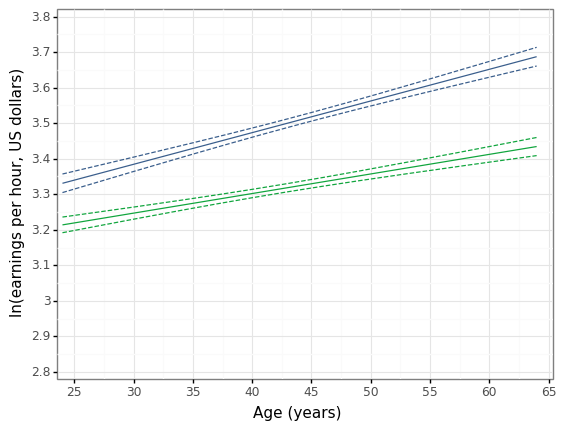

<ggplot: (336906858)>

In [27]:
ggplot(data_m, aes(x="age", y="fit")) + geom_line(
    colour=color[0]
) + geom_line(
    data_m, aes(x="age", y="CIup"), colour=color[0], linetype="dashed"
) + geom_line(
    data_m, aes(x="age", y="CIlo"), colour=color[0], linetype="dashed"
) + geom_line(
    data_f, aes(x="age", y="fit"), colour=color[1]
) + geom_line(
    data_f, aes(x="age", y="CIup"), colour=color[1], linetype="dashed"
) + geom_line(
    data_f, aes(x="age", y="CIlo"), colour=color[1], linetype="dashed"
) + labs(
    x="Age (years)", y="ln(earnings per hour, US dollars)"
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(24, 65), breaks=seq(25, 66, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=seq(2.8, 3.9, by=0.1)
) + theme_bw()

In [28]:
# PREDICTION AND GRAPH POLYNOMIAL
#male
data_m=cps.query("female==0")

pred=reg16.predict(data_m)

pred = reg16.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"]=data_m["fit"]+2*data_m["fit_se"]
data_m["CIlo"]=data_m["fit"]-2*data_m["fit_se"]

#female
data_f=cps.query("female==1")

pred=reg16.predict(data_f)

pred = reg16.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"]=data_f["fit"]+2*data_f["fit_se"]
data_f["CIlo"]=data_f["fit"]-2*data_f["fit_se"]

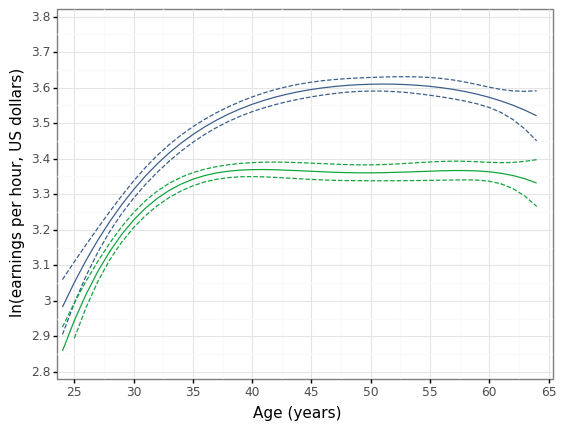

<ggplot: (336959001)>

In [29]:
ggplot(data_m, aes(x="age", y="fit")) + geom_line(
    colour=color[0]
) + geom_line(
    data_m, aes(x="age", y="CIup"), colour=color[0], linetype="dashed"
) + geom_line(
    data_m, aes(x="age", y="CIlo"), colour=color[0], linetype="dashed"
) + geom_line(
    data_f, aes(x="age", y="fit"), colour=color[1]
) + geom_line(
    data_f, aes(x="age", y="CIup"), colour=color[1], linetype="dashed"
) + geom_line(
    data_f, aes(x="age", y="CIlo"), colour=color[1], linetype="dashed"
) + labs(
    x="Age (years)", y="ln(earnings per hour, US dollars)"
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(24, 65), breaks=seq(25, 66, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=seq(2.8, 3.9, by=0.1)
) + theme_bw()

In [30]:
########################################################################
# Part 2
# TOWARDS CAUSAL ANALYIS - IS IT DISCRIMINATION?

In [31]:
# FILTER DATA -  SELECTION of the sample we need
cps = cps.query("age>=40 & age<=60")

In [32]:
cps["white"] = (cps["race"] == 1).astype(int)
cps["afram"] = (cps["race"] == 2).astype(int)
cps["asian"] = (cps["race"] == 4).astype(int)
cps["hisp"] = (cps["ethnic"].notna()).astype(int)
cps["othernonw"] = (
    (cps["white"] == 0) & (cps["afram"] == 0) & (cps["asian"] == 0) & (cps["hisp"] == 0)
).astype(int)
cps["nonUSborn"] = (
    (cps["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (cps["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)

In [33]:
# Potentially endogeneous demographics
cps['married']=((cps['marital']==1)|(cps['marital']==2)).astype(int)
cps['divorced']=((cps['marital']==3)&(cps['marital']==5)).astype(int)
cps['wirowed']=(cps['marital']==4).astype(int)
cps['nevermar']=(cps['marital']==7).astype(int)

cps['child0']=(cps['chldpres']==0).astype(int)
cps['child1']=(cps['chldpres']==1).astype(int)
cps['child2']=(cps['chldpres']==2).astype(int)
cps['child3']=(cps['chldpres']==3).astype(int)
cps['child4pl']=(cps['chldpres']>=4).astype(int)

# Work-related variables
cps['fedgov']=(cps['class']=="Government - Federal").astype(int)
cps['stagov']=(cps['class']=="Government - State").astype(int)
cps['locgov']=(cps['class']=="Government - Local").astype(int)
cps['nonprof']=(cps['class']=="Private, Nonprofit").astype(int)
cps['ind2dig']=((pd.Categorical(cps["ind02"]).codes+1)/100).astype(int)
cps['occ2dig']=(cps["occ2012"]/100).astype(int)
cps['union']=((cps['unionmme']=="Yes")|(cps['unioncov']=="Yes")).astype(int)


In [34]:
cps['uhourssq']=np.power(cps['uhours'],2)
cps['uhourscu']=np.power(cps['uhours'],3)
cps['uhoursqu']=np.power(cps['uhours'],4)

In [35]:
#### Extended regressions
reg1 = smf.ols(formula="lnw ~ female", data=cps).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw ~ female + age + ed_Profess + ed_Phd", data=cps).fit(
    cov_type="HC1"
)
reg3 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig)",
    data=cps,
).fit(cov_type="HC1")
reg4 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig) + agesq + agecu + agequ + uhoursqu + uhourscu + uhourssq",
    data=cps,
).fit(cov_type="HC1")

In [36]:
Stargazer([reg1,reg2,reg3,reg4])

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 161, but rank is 157
/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 167, but rank is 162
